In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras

2024-08-15 22:32:40.574272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 22:32:40.593123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 22:32:40.598975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 22:32:40.615253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 22:32:41.641968: W tensorflow/compiler/tf2

In [2]:
# preparing data
df = pd.read_csv('./data/jena_climate_2009_2016.csv')
df = df[5::6] # starting from 5, every 6th record = hourly

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S') # popping date_time 

df.head(5)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [3]:
date_time[:5]

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

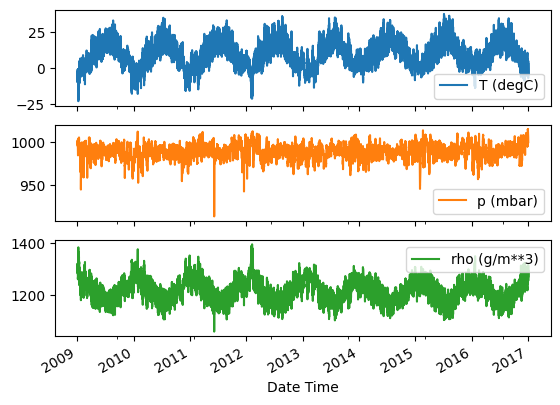

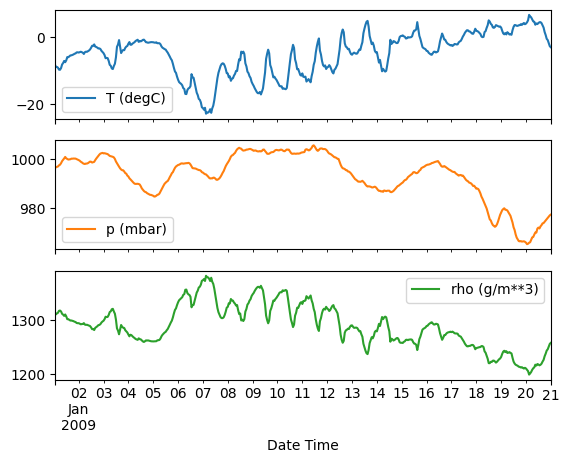

In [4]:
plt_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plt_features = df[plt_cols]
plt_features.index = date_time
plt_features.plot(subplots=True)

plt_features = df[plt_cols][:480]
plt_features.index = date_time[:480]
plt_features.plot(subplots=True)

In [5]:
# inspect dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [6]:
# wv = df['wv (m/s)']
# bad_wv = wv == -9999.0
# wv[bad_wv] = 0.0

In [7]:
# processing wind data
df["wv (m/s)"] = df["wv (m/s)"].replace(-9999.0, 0.0)
df["max. wv (m/s)"] = df["max. wv (m/s)"].replace(-9999.0, 0.0)

wv = df.pop('wv (m/s)')
max_wv = df.pop("max. wv (m/s)")

wd_rad = df.pop('wd (deg)')*np.pi / 180 # converting to radians
df['Wx'] = wv*np.cos(wd_rad) # calculating wind x components
df['Wy'] = wv*np.sin(wd_rad) # calculating wind y components
df['max Wx'] = max_wv*np.cos(wd_rad) # calculating max wind x components
df['max Wy'] = max_wv*np.sin(wd_rad) # calculating max wind y components

In [8]:
# processing date_time
timestamp_s = date_time.map(pd.Timestamp.timestamp) # convering into seconds

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [9]:
# splitting data
columns = {name: i for i, name in enumerate(df.columns)}
num_features = df.shape[1]

n = len(df)
train_split = 0.7
val_split = 0.9

train_df = df[:int(n*train_split)]
val_df = df[int(train_split*n):int(n*val_split)]
test_df = df[int(n*val_split):]

In [10]:
# normalizing data: subtract the mean and divide by the standard deviation of each feature
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/tmp/ipykernel_19480/1292398684.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.violinplot(x='Column', y='Normalized', data=df_std).set_xticklabels(df.keys(), rotation=90)


[Text(0, 0, 'p (mbar)'),
 Text(1, 0, 'T (degC)'),
 Text(2, 0, 'Tpot (K)'),
 Text(3, 0, 'Tdew (degC)'),
 Text(4, 0, 'rh (%)'),
 Text(5, 0, 'VPmax (mbar)'),
 Text(6, 0, 'VPact (mbar)'),
 Text(7, 0, 'VPdef (mbar)'),
 Text(8, 0, 'sh (g/kg)'),
 Text(9, 0, 'H2OC (mmol/mol)'),
 Text(10, 0, 'rho (g/m**3)'),
 Text(11, 0, 'Wx'),
 Text(12, 0, 'Wy'),
 Text(13, 0, 'max Wx'),
 Text(14, 0, 'max Wy'),
 Text(15, 0, 'Day sin'),
 Text(16, 0, 'Day cos'),
 Text(17, 0, 'Year sin'),
 Text(18, 0, 'Year cos')]

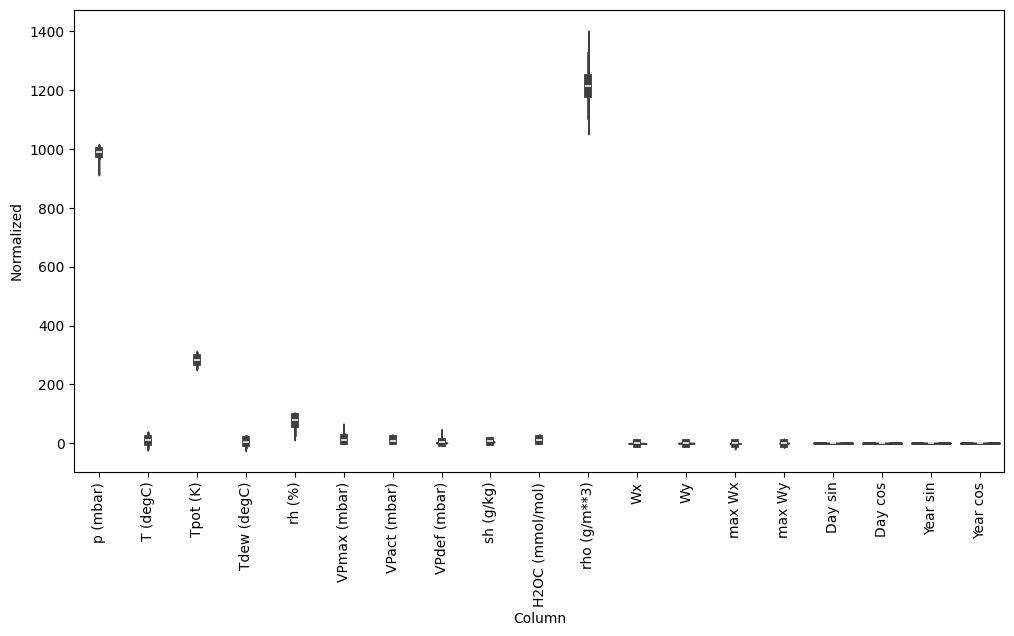

In [11]:
# visualizing the distribution of features
df_std = ((df - train_df.mean()) / train_df.std()).melt(var_name = "Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
sns.violinplot(x='Column', y='Normalized', data=df_std).set_xticklabels(df.keys(), rotation=90)

In [31]:
# creating windows for predictions
class WindowGenerator():
    # input_width: the size of given input
    # label_width
    # shift: time offset / predicted time
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # storing raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # label columns and indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # windows paramaters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([f'Total windows size: {self.total_window_size}', f'Input indices: {self.input_indices}', f'Label indices {self.label_indices}', f'Label column names: {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[: , self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # slicing doesnt preserve static shape information
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length= self.total_window_size,
            sequence_stride= 1,
            shuffle= True,
            batch_size= 32,
        )

        ds = ds.map(self.split_window)

        return ds
    
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [32]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)']) # predicting 24 more element
w1.train.element_spec

(TensorSpec(shape=(None, 24, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [36]:
# single step models
# if label_columns not defined, it returns all inputs
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['T (degC)'])
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['T (degC)'])

val_performance = {}
performance = {}

In [34]:
def compile_and_fit(model, window, patience=2, epochs=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=20, validation_data=window.val, callbacks=[early_stopping])
    return history

In [37]:
# linear model (no activation)
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)
history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)
Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.4487 - mean_absolute_error: 0.7802 - val_loss: 0.0556 - val_mean_absolute_error: 0.1860
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0444 - mean_absolute_error: 0.1587 - val_loss: 0.0125 - val_mean_absolute_error: 0.0836
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0122 - mean_absolute_error: 0.0810 - val_loss: 0.0087 - val_mean_absolute_error: 0.0689
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0087 - val_mean_absolute_error: 0.0688
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0692
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0697 - val_loss: 0.0088 - val_mean_absolute_error: 0.0698
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

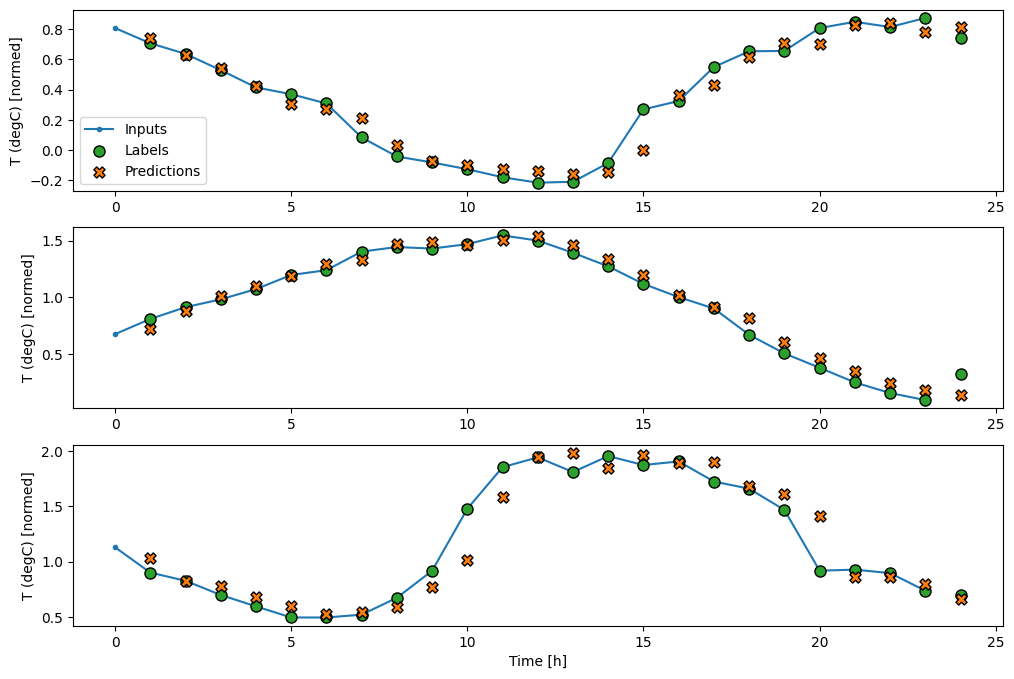

In [35]:
wide_window.plot(linear)

In [38]:
# dense
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0 ,return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0538 - mean_absolute_error: 0.1174 - val_loss: 0.0089 - val_mean_absolute_error: 0.0685
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0079 - mean_absolute_error: 0.0645 - val_loss: 0.0070 - val_mean_absolute_error: 0.0599
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0074 - mean_absolute_error: 0.0620 - val_loss: 0.0072 - val_mean_absolute_error: 0.0597
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0604 - val_loss: 0.0071 - val_mean_absolute_error: 0.0594
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073 - mean_absolute_error: 0.0603


In [42]:
# multi-step dense
CONV_WIDTH = 3
conv_window = WindowGenerator(input_width=CONV_WIDTH, label_width=1, shift=1, label_columns=['T (degC)']) # given 3 hours of inputs, predict 1 into the future
conv_window

Total windows size: 4
Input indices: [0 1 2]
Label indices [3]
Label column names: ['T (degC)']

In [40]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(), # (time,features) => (time*features)
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]) # (outputs) => (1, outputs)
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

history = compile_and_fit(multi_step_dense, conv_window)
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)
Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0476 - mean_absolute_error: 0.1362 - val_loss: 0.0106 - val_mean_absolute_error: 0.0768
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0079 - val_mean_absolute_error: 0.0649
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0639 - val_loss: 0.0071 - val_mean_absolute_error: 0.0610
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0618 - val_loss: 0.0067 - val_mean_absolute_error: 0.0579
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0605 - val_loss: 0.0065 - val_mean_absolute_error: 0.0569
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0599 - val_loss: 0.0065 - val_mean_absolute_error: 0.0560
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━

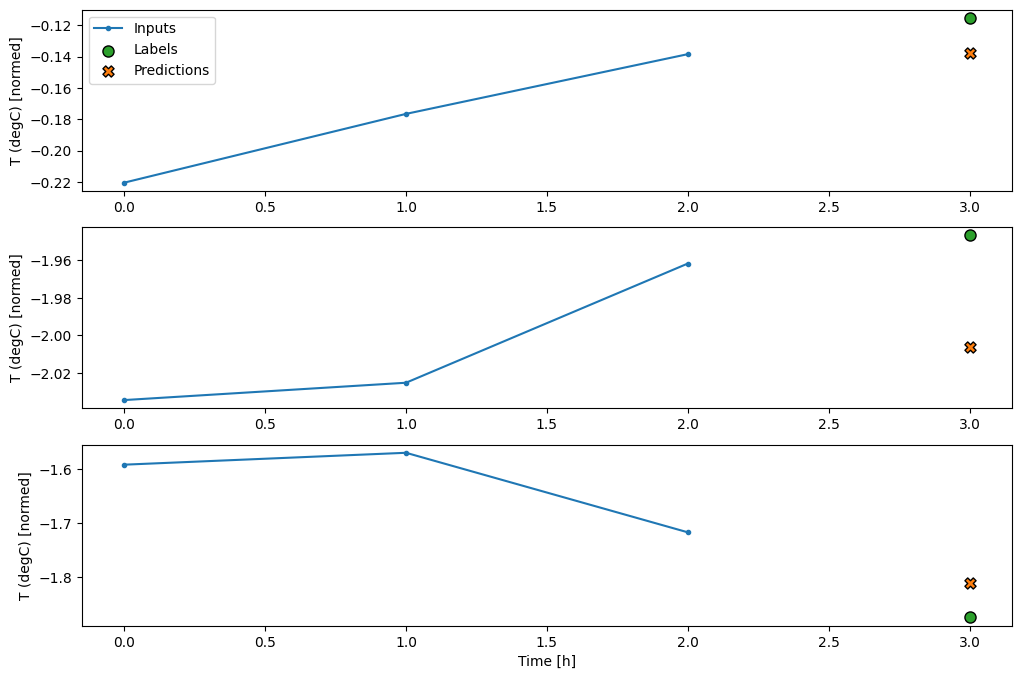

In [41]:
conv_window.plot(multi_step_dense)

In [43]:
# convolutional neural network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

history = compile_and_fit(conv_model, conv_window)
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)
Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0537 - mean_absolute_error: 0.1351 - val_loss: 0.0084 - val_mean_absolute_error: 0.0667
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0674 - val_loss: 0.0073 - val_mean_absolute_error: 0.0611
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0629 - val_loss: 0.0074 - val_mean_absolute_error: 0.0618
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0075 - mean_absolute_error: 0.0620 - val_loss: 0.0067 - val_mean_absolute_error: 0.0583
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0073 - mean_absolute_error: 0.0607 - val_loss: 0.0074 - val_mean_absolute_error: 0.0634
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0599 - val_loss: 0.0063 - val_mean_absolute_error: 0.0555
Epoch 7/20

In [44]:
# recurrent neural network
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True), # (batch,time,features) => (batch,time,lstm_units)
    tf.keras.layers.Dense(units=1), # (batch,time,features)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)


Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.1096 - mean_absolute_error: 0.1761 - val_loss: 0.0070 - val_mean_absolute_error: 0.0595
Epoch 2/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.0069 - mean_absolute_error: 0.0587 - val_loss: 0.0061 - val_mean_absolute_error: 0.0549
Epoch 3/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.0062 - mean_absolute_error: 0.0549 - val_loss: 0.0059 - val_mean_absolute_error: 0.0534
Epoch 4/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0060 - mean_absolute_error: 0.0535 - val_loss: 0.0058 - val_mean_absolute_error: 0.0527
Epoch 5/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0058 - mean_absolute_error: 0.0525 - val_loss: 0.0057 - val_mean_absolute_error: 0.0518
Epoch 6/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0056 - mean_absolute_error: 0.0519 - val_loss: 0.0057 - val_mean_absolute_error: 0.0516
Epoch 7/20
1533/1533 ━━━

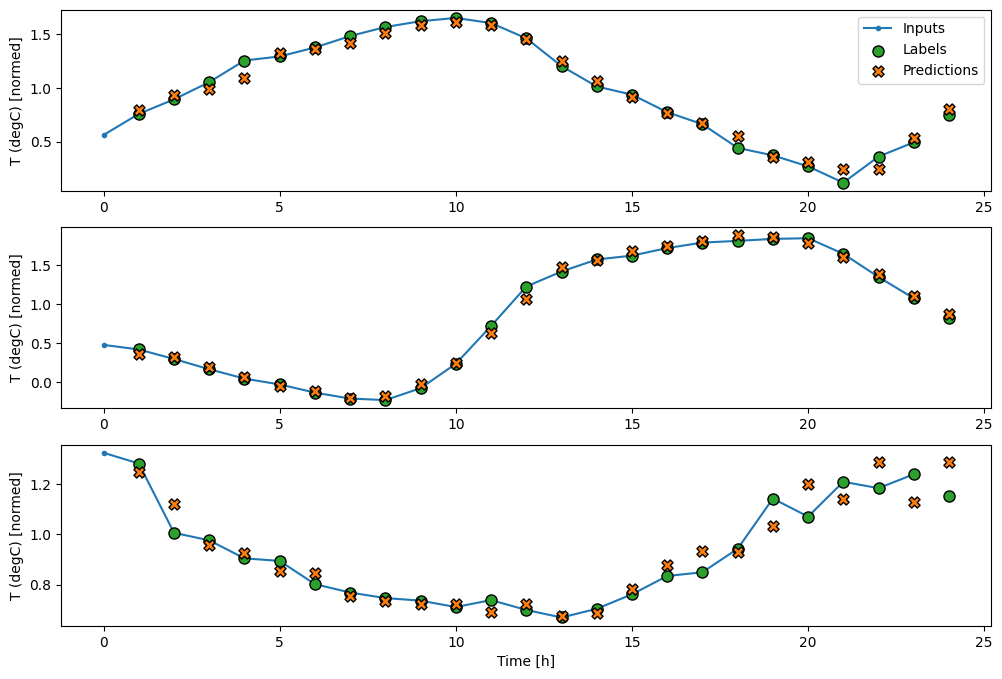

In [45]:
wide_window.plot(lstm_model)

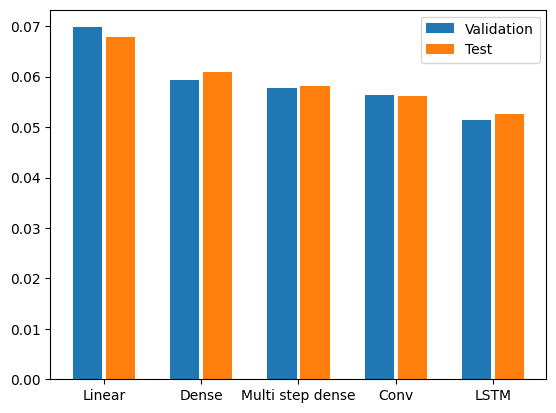

In [46]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys())
plt.legend()


In [47]:
# residual connections
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        
        return inputs + delta

In [48]:
%%time
residual_lstm = ResidualWrapper(tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.zeros()) # predicted deltas should start small
]))

history = compile_and_fit(residual_lstm, wide_window)
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.9754 - mean_absolute_error: 0.7716 - val_loss: 0.8426 - val_mean_absolute_error: 0.7328
Epoch 2/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.8943 - mean_absolute_error: 0.7562 - val_loss: 0.8421 - val_mean_absolute_error: 0.7323
Epoch 3/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.8932 - mean_absolute_error: 0.7557 - val_loss: 0.8419 - val_mean_absolute_error: 0.7326
Epoch 4/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.8936 - mean_absolute_error: 0.7559 - val_loss: 0.8419 - val_mean_absolute_error: 0.7322
Epoch 5/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.8932 - mean_absolute_error: 0.7557 - val_loss: 0.8419 - val_mean_absolute_error: 0.7325
Epoch 6/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.8932 - mean_absolute_error: 0.7557 - val_loss: 0.8419 - val_mean_absolute_error: 0.7327
Epoch 7/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.8931 - mea

In [49]:
# multi step models
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS) # predicts 24hrs into the future, given 24hrs of the past
multi_window

Total windows size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column names: None

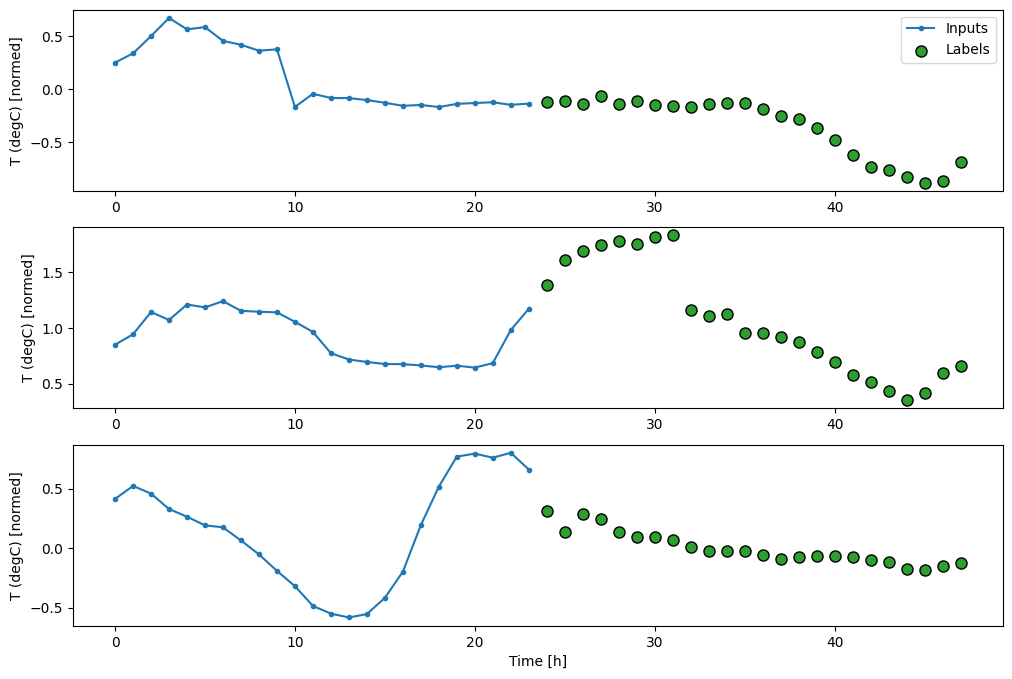

In [50]:
multi_window.plot()

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6250 - mean_absolute_error: 0.4987


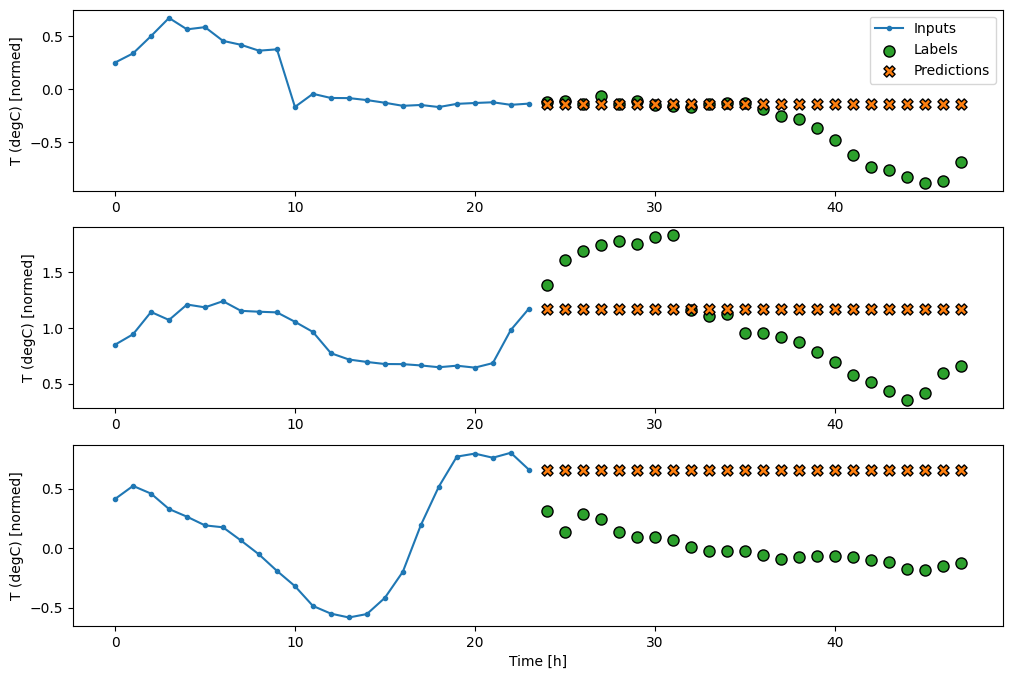

In [51]:
# baseline
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
    
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4241 - mean_absolute_error: 0.3945


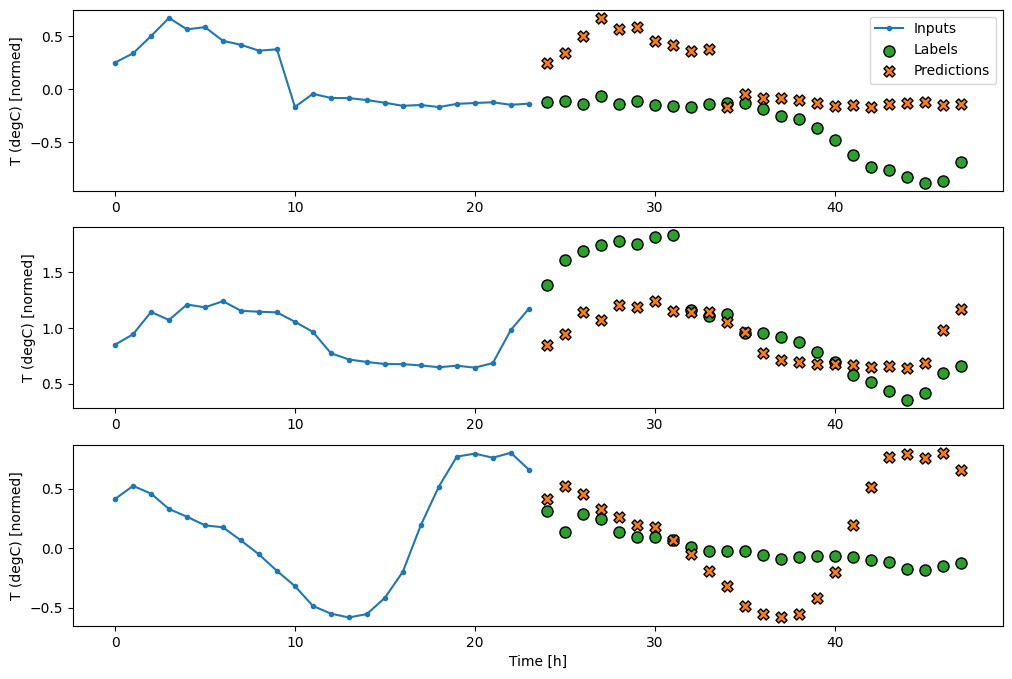

In [52]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs
    
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.4073 - mean_absolute_error: 0.4487 - val_loss: 0.2311 - val_mean_absolute_error: 0.3078
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2203 - mean_absolute_error: 0.2980 - val_loss: 0.2228 - val_mean_absolute_error: 0.2951
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2105 - mean_absolute_error: 0.2864 - val_loss: 0.2187 - val_mean_absolute_error: 0.2897
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.2058 - mean_absolute_error: 0.2813 - val_loss: 0.2182 - val_mean_absolute_error: 0.2896
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.2029 - mean_absolute_error: 0.2784 - val_loss: 0.2173 - val_mean_absolute_error: 0.2878
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2004 - mean_absolute_error: 0.2763 - val_loss: 0.2152 - val_mean_absolute_error: 0.2859
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.1985 - mea

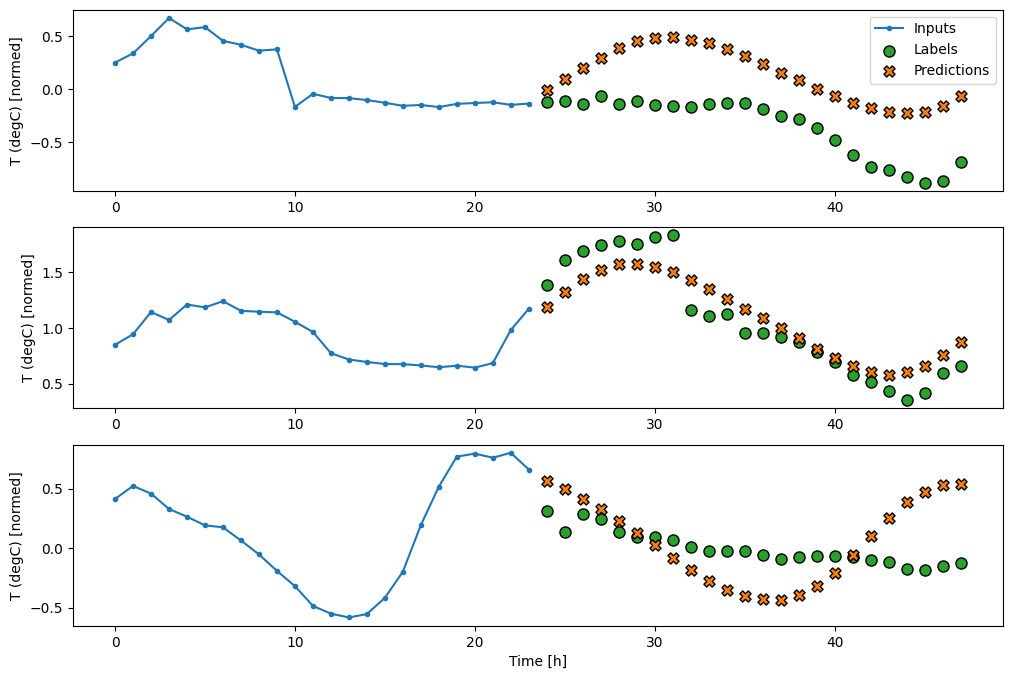

In [53]:
# single shot models
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features]),
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

In [54]:
# autoregressive model
from os import stat_result


class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units= units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True) # for warmup to work correctly
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs: (batch,time,features)
        # x: (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # prediction: (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=True):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - loss: 0.4305 - mean_absolute_error: 0.4687 - val_loss: 0.2529 - val_mean_absolute_error: 0.3334
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.2389 - mean_absolute_error: 0.3224 - val_loss: 0.2409 - val_mean_absolute_error: 0.3167
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.2262 - mean_absolute_error: 0.3075 - val_loss: 0.2316 - val_mean_absolute_error: 0.3083
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.2191 - mean_absolute_error: 0.2997 - val_loss: 0.2276 - val_mean_absolute_error: 0.3045
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.2154 - mean_absolute_error: 0.2957 - val_loss: 0.2257 - val_mean_absolute_error: 0.2994
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.2118 - mean_absolute_error: 0.2921 - val_loss: 0.2244 - val_mean_absolute_error: 0.3002
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.2093 - mea

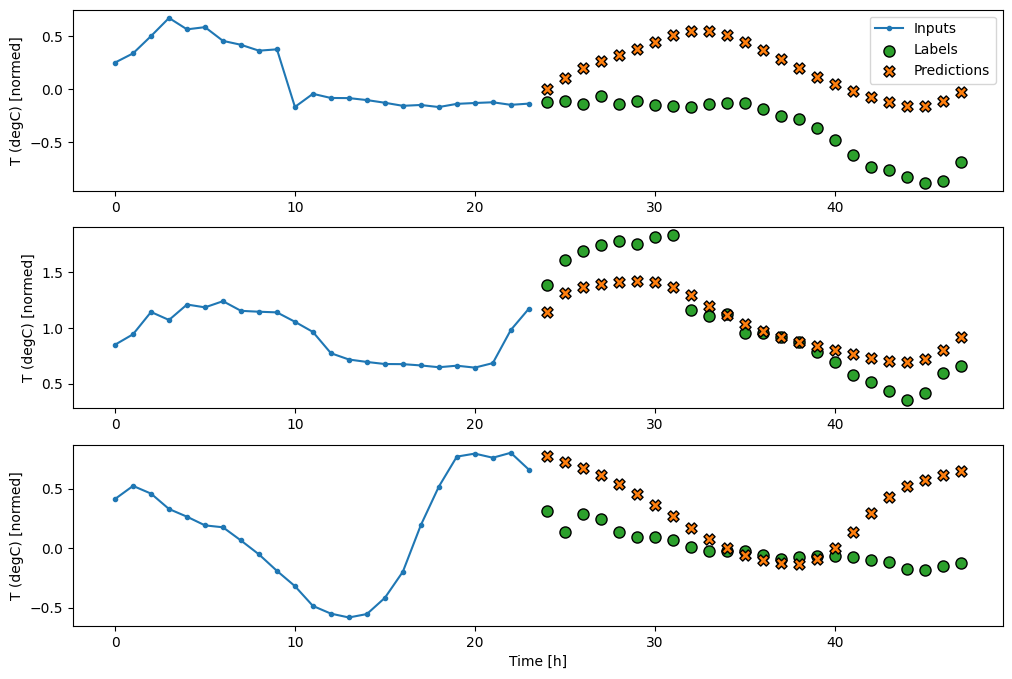

In [56]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

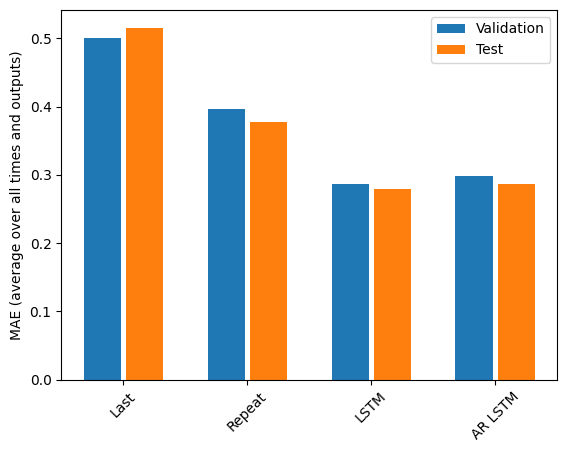

In [57]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()